# Deep Q-Learning

In this notebook, you will implement a deep Q-Learning reinforcement algorithm. The implementation borrows ideas from both the original DeepMind Nature paper and the more recent asynchronous version:<br/>
[1] "Human-Level Control through Deep Reinforcement Learning" by Mnih et al. 2015<br/>
[2] "Asynchronous Methods for Deep Reinforcement Learning" by Mnih et al. 2016.<br/>

In particular:
* We use separate target and Q-functions estimators with periodic updates to the target estimator. 
* We use several concurrent "threads" rather than experience replay to generate less biased gradient updates. 
* Threads are actually synchronized so we start each one at a random number of moves.
* We use an epsilon-greedy policy that blends random moves with policy moves.
* We taper the random search parameter (epsilon) and the learning rate to zero during training.

This gives a simple and reasonably fast general-purpose RL algorithm. We use it here for the Cartpole environment from OpenAI Gym, but it can easily be adapted to others. For this notebook, you will implement 4 steps:

1. The backward step for the Q-estimator
2. The $\epsilon$-greedy policy
3. "asynchronous" initialization 
4. The Q-learning algorithm

To get started, we import some prerequisites.

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,FMat,FND,GMat,GDMat,GIMat,GLMat,GSMat,GSDMat,GND,HMat,IDict,Image,IMat,LMat,Mat,SMat,SBMat,SDMat,TMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.JPlotting._
import BIDMach.Learner

import BIDMach.models.{Click,FM,GLM,KMeans,KMeansw,LDA,LDAgibbs,Model,NMF,SFA,RandomForest,SVD}
import BIDMach.networks.{Net}
import BIDMach.datasources.{DataSource,MatSource,FileSource,SFileSource}
import BIDMach.datasinks.{DataSink,MatSink}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,Grad,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}
import BIDMach.rl.ALE

Mat.checkMKL(false)
Mat.checkCUDA
Mat.setInline


1 CUDA device found, CUDA version 8.0


In [2]:
val ale = new ALE
ale.getFloat("repeat_action_probability")

0.25

The block below lists some parameters you can tune. They should be self-explanatory. They are currently set to train CartPole-V0 to a "solved" score (> 195) most of the time. 

In [3]:
val nsteps = 20000001                     // Number of steps to run (game actions per environment)
val npar = 16                            // Number of parallel environments
val target_window = 100                  // Interval to update target estimator from q-estimator
val discount_factor = 0.99f              // Reward discount factor
val printsteps = 10000                   // Number of steps between printouts
val render = false                       // Whether to render an environment while training

val epsilon_start = 0.5f                 // Parameters for epsilon-greedy policy: initial epsilon
val epsilon_end = 0.01f                  // Final epsilon
val neps = (0.9*nsteps).toInt            // Number of steps to decay epsilon

//val learning_rate = 5e-4f
val learning_rate = 3e-6f                // Initial learning rate
val lr_end = learning_rate               // Final learning rate
val nlr = neps                           // Steps to decay learning rate
val gsq_decay = 0.99f                   // Decay factor for RMSProp
val momentum_decay = 0.9f
val gclip = 1f
val rmseps = 1e-5f
val rmsevery = 10

val nhidden = 200                        // Number of hidden layers for estimators

val init_moves = 10000                   // Upper bound on random number of moves to take initially
val nwindow = 2                          // Sensing window = last n images in a state

2

Below are environment-specific parameters. The function "preprocess" should process an observation returned by the environment into a vector for training. For CartPole we simply append a 1 to implement bias in the first layer. 

For visual environments you would typically crop, downsample to 80x80, set color to a single bit (foreground/background), and flatten to a vector. 

*nfeats* is the dimension of the vector output by *preprocess*.

In [4]:
val game_bin="/code/ALE/roms/Pong.bin"                 // Model type and action definitions
val VALID_ACTIONS = irow(0, 3, 4)
val nactions= VALID_ACTIONS.length
val nfeats = 80*80                         

def preprocess(I:FND):FMat = {
//  Preprocess Pong game frames into vectors.
//  Input:
//    - (3,160,210) uint8 frame representing Pong game screen.
//  Returns:
//    - Downsampled (DxD) matrix of 0s and 1s, "raveled" into a 1-D vector.
    var i = 0;
    val res = zeros(80*80,1)
    while (i < 80) {
        var j = 0;
        while (j < 80) {
            val x = I.data(3*(j*2 + 160 * (i*2 + 35)));
            res.data(j + 80*i) = {if (x == 144f || x == 109f) 0f else {if (x != 0f) 1f else 0f}};
            j += 1;
        }
        i += 1;
    }
    res
}

def preprocess(I:Array[Byte]):FMat = {
//  Preprocess Pong game frames into vectors.
//  Input:
//    - (3,160,210) uint8 frame representing Pong game screen.
//  Returns:
//    - Downsampled (DxD) matrix of 0s and 1s, "raveled" into a 1-D vector.
    var i = 0;
    val res = zeros(80*80,1)
    while (i < 80) {
        var j = 0;
        while (j < 80) {
            val x = I(j*2 + 160 * (i*2 + 35));
            res.data(j + 80*i) = {if (x == 34) 0f else {if (x != 0) 1f else 0f}};
            j += 1;
        }
        i += 1;
    }
    res
}

Here is the Q-estimator class. We use two instances of this class, one for the target estimator, and one for the Q-estimator. The Q function is normally represented as a scalar $Q(x,a)$ where $x$ is the state and $a$ is an action. For ease of implementation, we actually estimate a vector-valued function $Q(x,.)$ which returns the estimated reward for every action. The model here has just a single hidden layer:

<pre>
Input Layer (nfeats) => FC Layer => RELU => FC Layer => Output (naction values)
</pre>

## 1. Implement Q-estimator gradient
Your first task is to implement the
<pre>Estimator.gradient(s, a, y)</pre>
method for this class. **gradient** should compute the gradients wrt weight arrays W1 and W2 into
<pre>self.grad['W1']
self.grad['W2']</pre>
respectively. Both <code>a</code> and <code>y</code> are vectors. Be sure to update only the output layer weights corresponding to the given action vector. 

In [5]:
import scala.collection.mutable.HashMap;

class Estimator(ninputs:Int, nhidden:Int, nactions:Int) {

//        """ Create model matrices, and gradient and squared gradient buffers"""
    val model = new HashMap[String, FMat]();
    val grad = new HashMap[String, FMat]();
    val velo = new HashMap[String, FMat]();
    val oldgrad = new HashMap[String, FMat]();
    val gradsq = new HashMap[String, FMat]();
    model("W1") = normrnd(0,1,nhidden, ninputs) / sqrt(ninputs)   // "Xavier" initialization
    model("W2") = normrnd(0,1,nactions, nhidden) / sqrt(nhidden)
    for ((k,v) <- model) {
         grad.put(k, zeros(v.nrows, v.ncols));
         velo.put(k, zeros(v.nrows, v.ncols));
         oldgrad.put(k, zeros(v.nrows, v.ncols));
         gradsq.put(k, zeros(v.nrows, v.ncols));
    } 

    def forward(s:FMat):(FMat, FMat) = {
//        """ Run the model forward given a state as input.
//    returns action predictions and the hidden state"""
        val h = model("W1") * s
        h ~ h *@ (h>=0)    // ReLU nonlinearity
        val rew = model("W2") * h
        (rew, h)
    }
    
    
    def predict(s:FMat):FMat = {
//        """ Predict the action rewards from a given input state"""
        val (rew, h) = forward(s)
        rew
    }
    
    var selector:IMat = irow(0->npar)*nactions
              
    def gradient(s:FMat, a:IMat, y:FMat):Float = {
//        """ Given a state s, action a and target y, compute the model gradients"""
        val (rew, h) = forward(s);
        val dout = y - rew(a + selector);     
        val arew = zeros(rew.nrows, rew.ncols);
        arew(a + selector) = dout
        
        grad("W2") ~ grad("W2") + (arew *^ h);
        val dh = model("W2") ^* arew
        dh ~ dh *@ (h > 0)
        
        grad("W1") ~ grad("W1") + (dh *^ s);

        sqrt((dout dotr dout)/dout.length).v
    }
    
    
    def rmsprop2(learning_rate:Float, decay_rate:Float) = {
//        """ Perform model updates from the gradients using RMSprop"""
        for ((k,v) <- model) {
            val g = grad(k);
            gradsq(k) = decay_rate * gradsq(k) + (1 - decay_rate) * (g *@ g)
            model(k) = model(k) + learning_rate * g / (sqrt(gradsq(k)) + 1e-5f)
            grad(k).clear
        }
    }
    
    def rmsprop1(learning_rate:Float, decay_rate:Float) = {
//        """ Perform model updates from the gradients using RMSprop"""
        for ((k,v) <- model) {
            val g = grad(k);
            gradsq(k) = decay_rate * gradsq(k) + (1 - decay_rate) * (g *@ g)
            model(k) = model(k) + learning_rate * g / (gradsq(k) + 1e-4f)
            grad(k).clear
        }
    }
    
    def rmsprop(learning_rate:Float, decay_rate:Float) = {
//        """ Perform model updates from the gradients using RMSprop"""
        for ((k,v) <- model) {
            val g = grad(k).data;
            val gsq = gradsq(k).data;
            val m = model(k).data;
            val len = grad(k).length;
            var i = 0;
            while (i < len) {
                val gi = math.min(gclip, math.max(-gclip, g(i)));
                gsq(i) = decay_rate * gsq(i) + (1-decay_rate) * gi * gi;
                m(i) += learning_rate * gi / (gsq(i) + rmseps);
                g(i) = 0;             
                i += 1;
            }
        }
    }
    
    def simple_grad(learning_rate:Float, decay_rate:Float) = {
//        """ Perform model updates from the gradients using RMSprop"""
        for ((k,v) <- model) {
            val g = grad(k).data;
            val m = model(k).data;
            val len = grad(k).length;
            var i = 0;
            while (i < len) {
                val gi = math.min(gclip, math.max(-gclip, g(i)));
                m(i) += learning_rate * gi
                g(i) = 0;             
                i += 1;
            }
        }
    }
    
    def adam(learning_rate:Float, gsq_decay:Float, momentum_decay:Float) = {
//        """ Perform model updates from the gradients using RMSprop"""
        for ((k,v) <- model) {
            val g = grad(k).data;
            val v = velo(k).data;
            val gsq = gradsq(k).data;
            val m = model(k).data;
            val len = grad(k).length;
            var i = 0;
            while (i < len) {
                val gi = math.min(gclip, math.max(-gclip, g(i)));
                v(i) = momentum_decay * v(i) + (1-momentum_decay) * gi;
                gsq(i) = gsq_decay * gsq(i) + (1-gsq_decay) * gi * gi;
                m(i) += learning_rate * gi / (gsq(i) + rmseps);
                g(i) = 0;             
                i += 1;
            }
        }
    }
}

## 2. Implement $\epsilon$-Greedy Policy

An $\epsilon$-Greedy policy should:
* with probability $\epsilon$ take a uniformly-random action.
* otherwise choose the best action according to the estimator from the given state.

The function below should implement this policy. For each input state, it should return a (column) vector of size nactions which are the probabilities of taking each action. Thus, the probabilities of non-optimal actions should be $\epsilon/{\rm nactions}$ and the probability of the best action should be $1-\epsilon+\epsilon/{\rm nactions}$.

Since the function processes batches of states, the input <code>state</code> is a <code>nfeatures x nbatch</code> matrix, and the returned value should be a <code>nactions x nbatch</code> matrix. 

In [6]:
val aselector = irow(0->npar)*nactions

def policy(estimator:Estimator, state:FMat, epsilon:Float):FMat = {
//    """ Take an estimator and state and predict the best action.
//    For each input state, return a vector of action probabilities according to an epsilon-greedy policy"""
    val A = ones(nactions, npar) * (epsilon / nactions)
    val q_values = estimator.predict(state)
    val (_,best_action) = maxi2(q_values)
    A(best_action + aselector) = A(best_action + aselector) + (1f - epsilon)
    A
}

This routine copies the state of one estimator into another. Its used to update the target estimator from the Q-estimator.

In [7]:
def update_estimator(to_estimator:Estimator, from_estimator:Estimator, window:Int, istep:Int) = {
//    """ every <window> steps, Copy model state from from_estimator into to_estimator"""
    if (istep % window == 0) {
        for ((k,v) <- from_estimator.model) {
            to_estimator.model(k) <-- from_estimator.model(k);
        }
    }
}

## 3. Implement "Asynchronous Threads"

Don't try that in Python!! Actually all we do here is create an array of environments and advance each one a random number of steps, using random actions at each step. Later on we will make *synchronous* updates to all the environments, but the environments (and their gradient updates) should remain uncorrelated. This serves the same goal as asynchronous updates in paper [2], or experience replay in paper [1].

In [8]:
// Create estimators
val q_estimator = new Estimator(nfeats*nwindow, nhidden, nactions)
val target_estimator = new Estimator(nfeats*nwindow, nhidden, nactions)

// The epsilon and learning rate decay schedules
// val epsilons = np.linspace(epsilon_start, epsilon_end, neps)
val epsilons = epsilon_start / (1f + row(0->neps)/(neps*epsilon_end/epsilon_start))
val learning_rates = learning_rate - row(0 -> nlr) * ((lr_end - learning_rate) / nlr)

// Initialize the games
print("Initializing games...")
val envs = new Array[ALE](npar)
val state = zeros(nfeats * nwindow, npar)
var total_time=0f
var total_steps=0
var total_epochs = 0

import java.util.Random
val rn = new Random

tic
for (i <- 0 until npar) {
    envs(i) = new ALE
    envs(i).setInt("random_seed", i)
    envs(i).loadROM(game_bin)

    val nmoves = rn.nextInt(init_moves - nwindow) + nwindow
    for (j <- 0 until nmoves) {   
        val action = VALID_ACTIONS(rn.nextInt(nactions))
        val (obs, reward, done) = envs(i).step(action)
        total_steps += 1;
        if (nmoves - j <= nwindow) {
            val k = nwindow - nmoves + j;
            state((k*nfeats)->((k+1)*nfeats), i) = preprocess(obs)
        }
        if (done) {
            envs(i).reset() 
            total_epochs += 1
        }
    }
}

total_time = toc     
println("%d steps, %d epochs in %5.4f seconds at %5.4f msecs/step" format(
    total_steps, total_epochs, total_time, 1000f*total_time/total_steps))


Initializing games...90123 steps, 73 epochs in 109.9990 seconds at 1.2205 msecs/step


Select integer actions using the probability distribution in each column of <code>probs</code>

In [9]:
def random_choices(probs:FMat):IMat = {
    val result = izeros(1, probs.ncols);
    var i = 0;
    while (i < probs.ncols) {
        val r = rn.nextFloat();
        var j = 0;
        var cumprob = probs(0, i);
        while (r > cumprob && j+1 < probs.length) {
            j += 1;
            cumprob += probs(j, i);
        }
        result(i) = j;
        i += 1
    }
    result
}

## 4. Implement Deep Q-Learning
In this cell you actually implement the algorithm. We've given you comments to define all the steps. You should also add book-keeping steps to keep track of the loss, reward and number of epochs (where env.step() returns done = true). 

In [10]:
tic
var block_loss = 0f
var block_reward = 0f
var total_reward = 0f
total_epochs = 0
var last_epochs = 0
val new_state = state.copy

val times = zeros(1,8)
val dtimes = zeros(1,7)
for (istep <- 0 until nsteps) {
//    if (render): envs[0].render()
    times(0) = toc
    val epsilon = epsilons(math.min(istep, neps-1));                                // get an epsilon for the eps-greedy policy
    val lr = learning_rates(math.min(istep, nlr-1));                                // update the decayed learning rate
    
    update_estimator(target_estimator, q_estimator, target_window, istep);          // update the target estimator if needed    
    times(1) = toc
    
    val action_probs = policy(q_estimator, state, epsilon);                         // get the next action probabilities from the policy
    times(2) = toc
                                                          
    val actions = random_choices(action_probs);                                     // Choose actions using the policy
    val (obs, rewards, dones) = ALE.stepAll2(envs, VALID_ACTIONS(actions))           // step through parallel envs
    times(3) = toc
    
    for (i <- 0 until npar) {                                                     
        val img = preprocess(obs(i));                                               // process the observation
        new_state(?,i) = state(nfeats->state.nrows,i) on img;                       // add it to buffer of last nwindow imgs        
    }    
    total_epochs += sum(dones).v.toInt
    block_reward += sum(rewards).v  
    times(4) = toc
    
    val q_values_next = target_estimator.predict(new_state);                        // predict the Q values
    times(5) = toc
    
    dones <-- (dones + (rewards != 0f) > 0f);
    val targets = rewards+discount_factor*(1f-dones) *@ maxi(q_values_next);        // compute target values   
    block_loss += q_estimator.gradient(state, actions, targets);                    // compute q-estimator gradient and return the loss
    times(6) = toc
    
    if (istep % rmsevery == 0) {
        q_estimator.rmsprop(lr, gsq_decay);                       // apply the gradient update
//        print("ds1=%f, ss1=%f, ds2=%f, ss2=%f\n" format(res(0,0), res(1,0), res(0,1), res(1,1)));
    }
    times(7) = toc
    
    dtimes ~ dtimes + (times(0,1->8) - times(0,0->7))
    val t = toc;
    if (istep % printsteps == 0) {
        total_reward += block_reward;
        println("step %d, time %2.1f, loss %9.8f, epochs %d, reward/epoch %6.5f, cum reward/epoch %6.5f" format(
                istep, t, block_loss/printsteps, total_epochs, block_reward/math.max(1,total_epochs-last_epochs), total_reward/math.max(1,total_epochs)))
        last_epochs = total_epochs;
        block_reward = 0f;
        block_loss = 0f;
    }
    state <-- new_state;
}
dtimes

step 0, time 0.1, loss 0.00000629, epochs 0, reward/epoch 0.00000, cum reward/epoch 0.00000
step 10000, time 196.9, loss 0.10600276, epochs 129, reward/epoch -20.28682, cum reward/epoch -20.28682
step 20000, time 413.3, loss 0.08713018, epochs 250, reward/epoch -20.28926, cum reward/epoch -20.28800
step 30000, time 635.6, loss 0.08261964, epochs 357, reward/epoch -20.12150, cum reward/epoch -20.23809
step 40000, time 860.1, loss 0.08161884, epochs 458, reward/epoch -19.18812, cum reward/epoch -20.00655
step 50000, time 1090.4, loss 0.07892536, epochs 557, reward/epoch -19.11111, cum reward/epoch -19.84740
step 60000, time 1321.1, loss 0.08794859, epochs 648, reward/epoch -19.16483, cum reward/epoch -19.75154
step 70000, time 1552.5, loss 0.08260289, epochs 740, reward/epoch -18.63043, cum reward/epoch -19.61216
step 80000, time 1790.9, loss 0.07963189, epochs 823, reward/epoch -18.51807, cum reward/epoch -19.50182
step 90000, time 2040.3, loss 0.08101470, epochs 903, reward/epoch -19.7

430.87,33327,1.3612e+05,25878,34203,1.3485e+05,1.3425e+05

And animate the model's performance. 

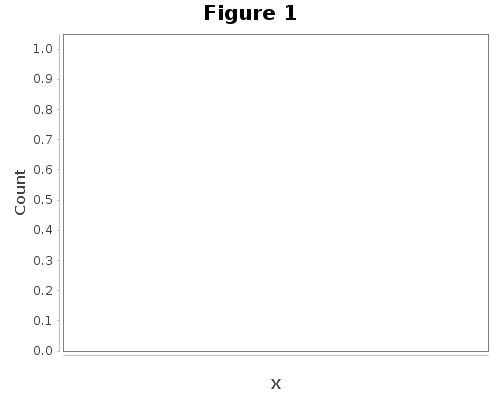

In [11]:
/*state0 = state[:,0]
for i in np.arange(200):
    envs[0].render()
    preds = test_estimator.predict(state0)
    iaction = np.argmax(preds)
    obs, _, done0, _ = envs[0].step(VALID_ACTIONS[iaction])
    state0 = np.concatenate((state0[nfeats:], preprocess(obs)))
    if (done0): envs[0].reset() */
//hist(ln(abs(q_estimator.gradsq("W1")(?))),100)
//    hist(ln(abs(q_estimator.gradsq("W1")(?))),100)

So there we have it. Simple 1-step Q-Learning can solve easy problems very fast. Note that environments that produce images will be much slower to train on than environments (like CartPole) which return an observation of the state of the system. But this model can still train on those image-based games - like Atari games. It will take hours-days however. 

In [12]:
//q_estimator.gradient(state,actions,targets)

: 

In [13]:
//saveFMat("BestW1.fmat.lz4",q_estimator.model("W1"))
//saveFMat("BestW2.fmat.lz4",q_estimator.model("W2"))

In [17]:
val test_steps = 100001;
val testprintsteps = 10000;

val test_estimator = new Estimator(nfeats*nwindow, nhidden, nactions);
test_estimator.model("W1") = loadFMat("BestW1.fmat.lz4");
test_estimator.model("W2") = loadFMat("BestW2.fmat.lz4");

block_reward = 0f;
total_reward = 0f;
total_epochs = 0;
last_epochs = 0;

tic;
for (istep <- 0 until test_steps) {
    
    val action_probs = policy(test_estimator, state, 0);                    // get the next action probabilities from the policy                                                         
    val actions = random_choices(action_probs);                             // Choose actions using the policy
    val (obs, rewards, dones) = ALE.stepAll2(envs, VALID_ACTIONS(actions))  // step through parallel envs   
    for (i <- 0 until npar) {                                                     
        val img = preprocess(obs(i));                                       // process the observation
        state(?,i) = state(nfeats->state.nrows,i) on img;                   // add it to buffer of last nwindow imgs        
    }    
    total_epochs += sum(dones).v.toInt
    block_reward += sum(rewards).v  
    
    val t = toc;
    if (istep % testprintsteps == 0) {
        total_reward += block_reward;
        println("step %d, time %2.1f, epochs %d, reward/epoch %6.5f, cum reward/epoch %6.5f" format(
                istep, t, total_epochs, block_reward/math.max(1,total_epochs-last_epochs), total_reward/math.max(1,total_epochs)))
        last_epochs = total_epochs;
        block_reward = 0f;
    }
}



step 0, time 0.0, epochs 0, reward/epoch 0.00000, cum reward/epoch 0.00000
step 10000, time 93.0, epochs 22, reward/epoch 8.81818, cum reward/epoch 8.81818
step 20000, time 186.3, epochs 47, reward/epoch 7.56000, cum reward/epoch 8.14894
step 30000, time 279.1, epochs 72, reward/epoch 10.20000, cum reward/epoch 8.86111
step 40000, time 372.2, epochs 101, reward/epoch 7.65517, cum reward/epoch 8.51485
step 50000, time 465.1, epochs 124, reward/epoch 9.91304, cum reward/epoch 8.77419
step 60000, time 557.9, epochs 149, reward/epoch 8.76000, cum reward/epoch 8.77181
step 70000, time 650.7, epochs 173, reward/epoch 9.54167, cum reward/epoch 8.87861
step 80000, time 743.6, epochs 198, reward/epoch 8.48000, cum reward/epoch 8.82828
step 90000, time 836.5, epochs 223, reward/epoch 9.52000, cum reward/epoch 8.90583
step 100000, time 929.4, epochs 247, reward/epoch 8.20833, cum reward/epoch 8.83806
